# Training ANNs

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/deep-learning-intro/">https://d9w.github.io/deep-learning-intro/</a><br>Based on the Supaero Data Science Deep Learning class: https://supaerodatascience.github.io/deep-learning/

Let's keep using the same network:

<img src="img/nn2.png" width="600px"></img>

In this section, we will see how to train or learn the weights and biases of the network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
sizes = [2,4,3,1]
num_layers = len(sizes)
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

In [2]:
def forward_pass(x, verbose=False):
    y = [np.zeros((x.shape[0], sz)) for sz in sizes]
    y[0] = x.copy()
    for i in range(1,len(sizes)):
        if verbose:
            print("# Forward propagation to layer", i)
        inputs = np.dot(y[i-1],weights[i-1].T) + biases[i-1]
        if verbose:
            print("Neuron inputs:", inputs)
        if i == len(sizes)-1:
            y[i] = inputs # final identity neuron
        else:
            y[i] = sigmoid(inputs)
        if verbose:
            print("Layer outputs:", y[i])
    return y

We'll also introduce some visualization code to see the parameters of the network.

In [3]:
# Graph plotting
import networkx as nx

ids = np.append([0], np.cumsum(sizes))
id_layers = []
G = nx.Graph()
for l in range(1, len(ids)):
    id_layers.append([i for i in range(ids[l-1], ids[l])])
for l in range(len(id_layers)):
    for i in id_layers[l]:
        G.add_node(i, subset=l)
for l in range(1, len(id_layers)):
    for i in id_layers[l-1]:
        for j in id_layers[l]:
            G.add_edge(i, j)
            
def get_param_colors(weights, biases):
    w = [i for l in weights for i in l.flatten()]
    b = np.concatenate((np.zeros(sizes[0]),
                         [i for l in biases for i in l.flatten()]))
    return np.copy(w), np.copy(b)

options = {
    "width": 4,
    "cmap": plt.cm.Reds,
    "edge_cmap": plt.cm.Blues,
    "with_labels": True,
}
pos = nx.multipartite_layout(G)

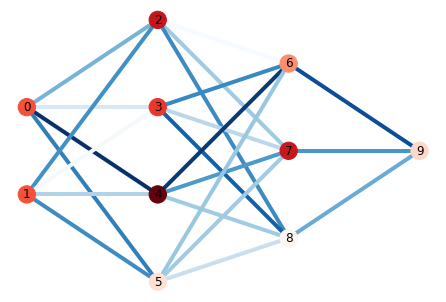

In [4]:
w, b = get_param_colors(weights, biases)
nx.draw(G, pos, **options, edge_color=w, node_color=b)

# Learning the weights of a neural network

Suppose that the value associated to $x=[1,2]$ in the previous example was $12.3$. That is not what was predicted and we could wish to adapt the weights of the network so that the next time we propagate $x=[1,2]$ through the network, the prediction is closer to $12.3$. Let's assume that we have many points like this, where we know what we want the network to predict, and that our data points $(x,y)$ are drawn from a probability distribution $p(x,y)$. We will use them to change the parameters (weights and biases) of the ANN.

## Loss function

A neural network with a fixed graph structure is a parametric function $f_\theta$ where $\theta$ is the vector of all parameters (all weights and biases). Learning a neural network that correctly predicts $y$ corresponds to finding the parameters $\theta$ that minimize the following function.

$$L(\theta) = \displaystyle \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] = \int_{x,y} \left[ \left(f_\theta(x) - y\right)^2 \right] \mathrm{d}p(x,y) $$

This is what we shall call the *loss function*. The smaller $L(\theta)$, the happier we are.

Note that we have defined $L(\theta)$ as a least squares minimization problem and that other loss functions could be used.

In [5]:
input_X = np.array([[1.,2.],[1.1,1.7],[0.8,1.9]])
def func(x):
    return np.sqrt(x[:,0]+x[:,1])
output_y = func(input_X)

In [6]:
pred = forward_pass(input_X, verbose=False)[-1]
print("Ground truth: ", output_y)
print("Prediction: ", pred.flatten())
err = np.mean((pred-output_y)**2)
print("Loss function estimate:", err)

Ground truth:  [1.73205081 1.67332005 1.64316767]
Prediction:  [0.54112415 0.50237889 0.54072257]
Loss function estimate: 1.3351882570736453


## Stochastic gradient descent

Let's say we have an initial guess $\theta_0$ for the parameters of $f_\theta$. How can we change this guess so that we minimize $L(\theta)$? Plain gradient descent tells us we should move in the opposite direction of the gradient of $L(\theta)$ with respect to $\theta$. So let's write this gradient:

\begin{align*}
\displaystyle \nabla_\theta L(\theta) &= \nabla_\theta \left[ \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \nabla_\theta \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \right]
\end{align*}

So, the gradient of $L(\theta)$ is the expectation of $2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x)$. In other words:

$$\nabla_\theta L(\theta) = \int_{x,y} 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \mathrm{d}p(x,y)$$


The problem with this expression is that it requires the knowledge of $p(x,y)$ for all possible $(x,y)$ pairs. That would mean having an infinite amount of data. We can, however, try to approximate this gradient with a finite data set $\left\{\left(x_i,y_i\right)\right\}_{i\in [1,N]}$:
$$\nabla_\theta L(\theta) \approx \sum_{i=1}^N 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i)$$


The theory of *stochastic gradient descent* tells us that if $g(\theta)$ is a noisy estimator of $\nabla_\theta L(\theta)$, then the following sequence $\theta_k$ converges to a local minimum of $L(\theta)$:
$$\theta_{k+1} = \theta_k - \alpha_k g(\theta_k)$$
under the condition that $\sum \alpha_k = \infty$ and $\sum \alpha_k^2 < \infty$ (called the Robbins-Monro conditions).

**A Stochastic Approximation Method**.
H. Robbins and S. Monro (1951). *The Annals of Mathematical Statistics*. **22**(3): 400. 

The first condition $\sum \alpha_k = \infty$ insures that whatever the starting parameters $\theta_0$, no matter how far from $\theta_0$ the minimum is, this procedure can reach it.

The second condition $\sum \alpha_k^2 < \infty$ forces the step sizes to be a decreasing sequence and avoids oscillations around the minimum.

Here we have
$$g(\theta) = \sum_{i=1}^N 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i).$$

To simplify the notation we shall write $\alpha$ instead of $\alpha_k$.

Using our data, we'll estimate the gradient and use this estimate to update the parameters of the network. We call one complete pass (to compute the $\sum_{i=1}^N$) over the training set a *training epoch*.

## Minibatches

Now we have a procedure that allows to find some optimal weights for our network. However, for large datasets, summing over the $N$ elements is computationally expensive. So we could define a cheaper (but noiser) version of the gradient by summing only over a random subset of $n$ training points ($n \ll N$): 
$$\nabla_\theta L(\theta) \approx g(\theta) = \sum_{i=1}^n 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i) $$

Such a subset is called a *minibatch*. When $n=1$, the gradient estimate is based on a single example and is thus very (very!) noisy and convergence can be very slow and unstable. When $n\rightarrow N$ the noise level decreases at the expense of a heavier computational cost. In practice, the noise level decreases quickly enough that we can take $n\in [50;1000]$ in most cases.

# Backpropagation

<img src="img/nn3.png" width="600px"></img>

Stochastic gradient descent informs us of how the outputs of the network should be modified based on the provided labels. However, it doesn't tell us how all of the parameters of the network should be updated beyond the output layers. We need to calculate the gradient update for all parameters in the network, starting from the output layer (where we have the gradient information), and working our way back. This is known as backpropagation.

Rumelhart, David E., Geoffrey E. Hinton, and Ronald J. Williams. "Learning representations by back-propagating errors." Nature 323.6088 (1986): 533-536.


 Let's consider neuron number $j$ and let's write $w_{ij}$ its input weights (with the convention that $i=0$ corresponds to the bias). We will write:
- $x_{ij}$ the $i$th input to this neuron
- $y_j = \sum_i w_{ij} x_{ij}$ the scalar input to the activation function
- $z_j = \sigma (y_j)$ the neuron's output
<img src="img/neuronj-0.png" width="300px"></img>

These three quantities have been computed during the *forward pass*, when $x$ was propagated through the network to obtain $f_\theta(x)$.

The key to backpropagation is to remark that in all cases:
$$\frac{\partial f_\theta}{\partial w_{ij}}(x) = \delta_j x_{ij}.$$

With 
$$\delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j).$$

If neuron $j$ is an output neuron, then $z_j$ is the $j$th component of $f_\theta(x)$. So $ \frac{\partial f_\theta}{\partial z_j}(x) = 1$. Consequently, for those neurons:
$$\delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j) = \sigma'(y_j).$$


Recursively, once all the $\delta_j$ for the output layer have been computed, we can compute the $\delta_j$ for the last hidden layer as:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}.$$

And the input weights of neuron $j$ can be updated as:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right) \delta_j x_{ij}.$$

Once, all these weights have been updated and all the $\delta_j$ have been computed for the corresponding neurons, we can move one layer back in the network, and so on until we reach the input layer.

<img src="img/nn3.png" width="600px"></img>

- in red, the network's data: w[i] and b[i] store the weights and biases,
- in blue, what is computed during the forward pass, y[i] for $w^x$, s[i] for $\sigma'(x)$, z[i] for neuron activations,
- in green, what is computed during the backward pass, $\delta$[i] and the weights and biases updates.

Updating the network therefore happens in two steps: a forward pass and a backpropagation of the gradient.

### Forward pass

<div class="alert alert-success">    
<ol style="list-style-type:none">
<li> Input $x$
<li> $\lambda=$input layer
<li> While $\lambda\neq$ output layer:
    <ol style="list-style-type:none">
    <li>For $j$ in $\lambda$:
        <ol  style="list-style-type:none"><li>Compute $y_j=\sum w_{ij} x_{ij}$ and $z_j=\sigma(y_j)$</ol>
    <li> $\lambda \leftarrow$ next layer
    <li> $x \leftarrow z$
    </ol>
<li> Output $f_\theta(x)$
</ol>
</div>

### Backpropagation

<div class="alert alert-success">
<ol style="list-style-type:none">
<li> Output difference $\Delta = f_\theta(x) - y$
<li> For $j$ in output layer $\delta_j = \sigma'(y_j)$
<li> $\lambda =$ output layer
<li> While layer $\lambda \neq$ input layer:
    <ol style="list-style-type:none">
    <li> For $j$ in $\lambda$:
        <ol style="list-style-type:none">
        <li>Compute $\delta_j = \sigma'(y_j) \sum_{l\in L} \delta_l w_{jl}$ (only if not output layer)
        <li>Update $w_{ij} \leftarrow w_{ij} - \alpha \Delta \delta_j x_{ij}$</ol>
    <li> $\lambda=$previous layer
    </ol>
</ol>
</div>

# Backpropagation in practice


<img src="img/nn3.png" width="600px"></img>

In [7]:
def sigmoid(z):
    """The sigmoid function."""
    val = 1.0/(1.0+np.exp(-z))
    der = val*(1.-val)
    return val, der

In [8]:
def forward_pass(x, verbose=False):
    z = [np.zeros((x.shape[0], sz)) for sz in sizes]
    s = [np.zeros((x.shape[0], sz)) for sz in sizes]
    y = [np.zeros((x.shape[0], sz)) for sz in sizes]
    z[0] = x.copy()
    for i in range(1,len(sizes)):
        if verbose:
            print("# Forward propagation to layer", i)
        y[i] = np.dot(z[i-1],weights[i-1].T) + biases[i-1]
        if verbose:
            print("Neuron inputs:", y[i])
        if i==len(sizes)-1:
            s[i] = np.ones((x.shape[0],sizes[-1]))
            z[i] = y[i]
        else:
            v, d  = sigmoid(y[i])
            s[i] = d
            z[i] = v
        if verbose:
            print("Layer outputs:", z[i])
    return y,s,z

Let's consider a batch of three training samples: $\left(x=(1,2),y=12.3\right)$, $\left(x=(3,1),y=3.4\right)$ and $\left(x=(2,5),y=5.1\right)$.

In [9]:
input_value = np.array([[1,2],[3,1],[2,5]])
output_value = np.array([[12.3],[3.4],[5.1]])
y,s,z = forward_pass(input_value, verbose=False)

In [10]:
print(*z, sep="\n")

[[1 2]
 [3 1]
 [2 5]]
[[7.11320007e-02 9.89135250e-01 5.99559098e-02 5.01203648e-01]
 [2.47387689e-01 9.99737823e-01 6.64285182e-01 9.77744780e-02]
 [9.68811374e-04 9.99950503e-01 2.42449582e-04 8.23412807e-01]]
[[0.38891116 0.8955035  0.11918183]
 [0.33093125 0.95819493 0.12526132]
 [0.4802297  0.90573904 0.09097056]]
[[0.54112415]
 [0.47079792]
 [0.7114858 ]]


In [11]:
def backward_pass(out, y, s, z, alpha):
    delta = [np.zeros((out.shape[0], sz)) for sz in sizes]
    error = z[len(sizes)-1] - out
    for i in range(len(sizes)-1,0,-1):
        # compute delta
        if i==len(sizes)-1:
            delta[i] = s[len(sizes)-1]
        else:
            delta[i] = np.dot(delta[i+1],weights[i])
            delta[i] = np.multiply(delta[i],s[i])
        # intermediate delta value that includes the error term 
        # (useful for minibatches since each element has a different error value)
        delta_temp = np.multiply(delta[i],error)
        # update weights
        grad_w = np.dot(delta_temp.T,z[i-1])
        grad_b = np.sum(delta_temp, axis=0)
        weights[i-1] -= alpha * grad_w
        biases[i-1]  -= alpha * grad_b
    return

Now that we have a backpropagation method, let's see how the weights update.

In [12]:
backward_pass(output_value, y, s, z, 0.1)

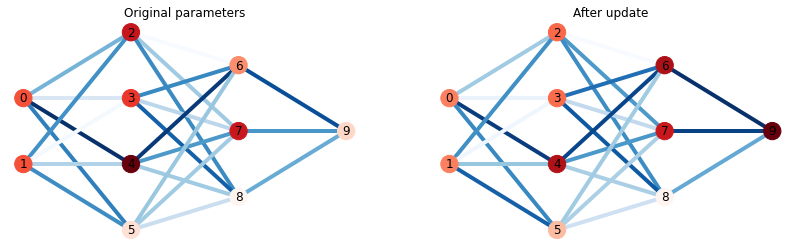

In [13]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Original parameters")
nx.draw(G, pos, **options, edge_color=w, node_color=b)

nw, nb = get_param_colors(weights, biases)
plt.subplot(1, 2, 2)
plt.title("After update")
nx.draw(G, pos, **options, edge_color=nw, node_color=nb)

It is helpful during neural network training to watch the error. Based on stochastic gradient descent, this value should go down as we iterate over the data multiple times. We will re-initialize our neural network and observe the training loss over multiple epochs.

In [14]:
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

In [15]:
nsteps = 500
training_loss = np.zeros(nsteps)
for i in range(nsteps):
    y,s,z = forward_pass(input_value, verbose=False)
    training_loss[i] = np.mean((z[-1]-output_value)**2)
    backward_pass(output_value, y, s, z, 0.1)

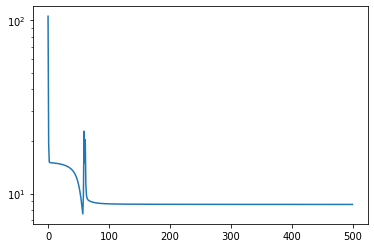

In [16]:
import matplotlib.pyplot as plt
plt.semilogy(training_loss);

The loss has greatly descended! That should mean that the network now knows to predict the ground truth for the three points used during training. We can verify that.

In [17]:
y,s,z = forward_pass(input_value, verbose=False)
print(z[-1])
print(output_value)

[[8.69545867]
 [3.40861602]
 [8.69816303]]
[[12.3]
 [ 3.4]
 [ 5.1]]


Ok. It seems to work, we've learned a network that can memorize the three point-wise mappings:
$$\begin{array}{ccc} 
(1,2) & \rightarrow & 12.3\\
(3,1) & \rightarrow & 3.4 \\
(2,5) & \rightarrow & 5.1
\end{array}$$

That's a good start. Let's try to generalize this to any number of points. <br>
Let's re-initialize and check the learning on the noise-less function $x_0,x_1\mapsto \sqrt{x_0+x_1}$.<br>
This time we will visualize both the training and testing error.

In [18]:
sizes = [2, 4, 3, 1]
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

In [19]:
# generate training and testing sets
def func(x):
    return np.sqrt(x[:,0]+x[:,1])

testing_x  = np.random.uniform(size=(100,2))
testing_y  = func(testing_x).reshape(-1,1)
training_x = np.random.uniform(size=(100,2))
training_y = func(training_x).reshape(-1,1)

# compute initial generalization loss
y,s,z = forward_pass(testing_x, verbose=False)
err = np.mean((z[-1]-testing_y)**2)
print("Generalization loss estimate:",err)

Generalization loss estimate: 1.145706100577574


In [20]:
nsteps = 1000
training_loss = np.zeros(nsteps)
testing_loss  = np.zeros(nsteps)

for i in range(nsteps):
    _,_,z_test = forward_pass(testing_x, verbose=False)
    testing_loss[i]  = np.mean((z_test[-1]-testing_y)**2)
    y_train,s_train,z_train = forward_pass(training_x, verbose=False)
    training_loss[i] = np.mean((z_train[-1]-training_y)**2)
    backward_pass(training_y, y_train, s_train, z_train, 0.001)

last training loss: 0.03472007527443936
last generalization loss: 0.0407010799953677


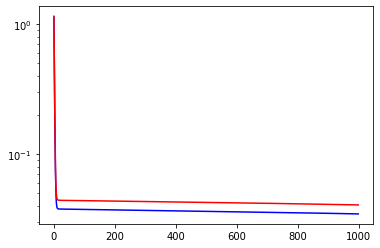

In [21]:
plt.semilogy(training_loss, c='b')
plt.semilogy(testing_loss, c='r')
print("last training loss:", training_loss[-1])
print("last generalization loss:", testing_loss[-1])

Let's try some random values to see if the network learned the function $x_0,x_1\mapsto \sqrt{x_0+x_1}$.

In [22]:
x = np.random.uniform(size=(3,2))
ztrue = func(x).reshape(-1,1)
print("Ground truth: ", ztrue)
_,_,zpred = forward_pass(x)
print("Prediction: ", zpred[-1])
print("Error: ", ztrue-zpred[-1])

Ground truth:  [[1.05403218]
 [0.87847435]
 [0.88095842]]
Prediction:  [[1.00183841]
 [0.98775367]
 [0.98290032]]
Error:  [[ 0.05219377]
 [-0.10927932]
 [-0.1019419 ]]


<div class="alert alert-warning">
    <b>Exercise</b>
    
Try different architectures. Keep in mind the universal approximation theorem and how the number of neurons influences the approximation capacity.
    </div>

# Multi-Layer Perceptron in scikit-learn

We wrote backpropagation ourselves, but there are many libraries which already implement it! In the next notebook, we'll see how PyTorch uses autodifferentiation to construct an entire gradient chain, but we can also do backpropagation with scikit-learn. The Multi-Layer Perceptron model is an ANN with any activation functions and can be trained using SGD and backpropagation.

We will try to learn the function $x \sin(x)$ by using noisy points around this line. We start by generating the data.

In [23]:
def func(x):
    x = 15.*x-5.
    return x*np.sin(x)

sigma_noise = 0.3
def observation(x):
    return func(x) + np.random.normal(0,sigma_noise,x.shape[0])

X = np.linspace(0,1,1000)
N = X.shape[0]
Y = observation(X)
x = np.linspace(0,1,100)

nb points: 1000


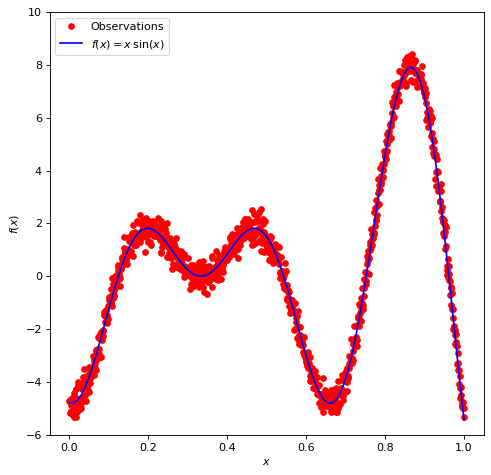

In [24]:
fig=plt.figure(figsize=(7,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, func(x), 'b', label=u'$f(x) = x\,\sin(x)$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

print("nb points:", N)

As with the previous example, we are using a neural network for regression, ie, we aim to predict a single value and base the gradient on the difference from our prediction and the ground truth. We will use the `MLPRegressor` class.

In [25]:
from sklearn.neural_network import MLPRegressor
myNN = MLPRegressor(hidden_layer_sizes=(100,10), activation='tanh', solver='lbfgs', max_iter=5000, learning_rate_init=0.1) 

In [26]:
X=X.reshape(-1,1)
myNN.fit(X,Y)

MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 10),
             learning_rate_init=0.1, max_iter=5000, solver='lbfgs')

In [27]:
ypredict = myNN.predict(X)

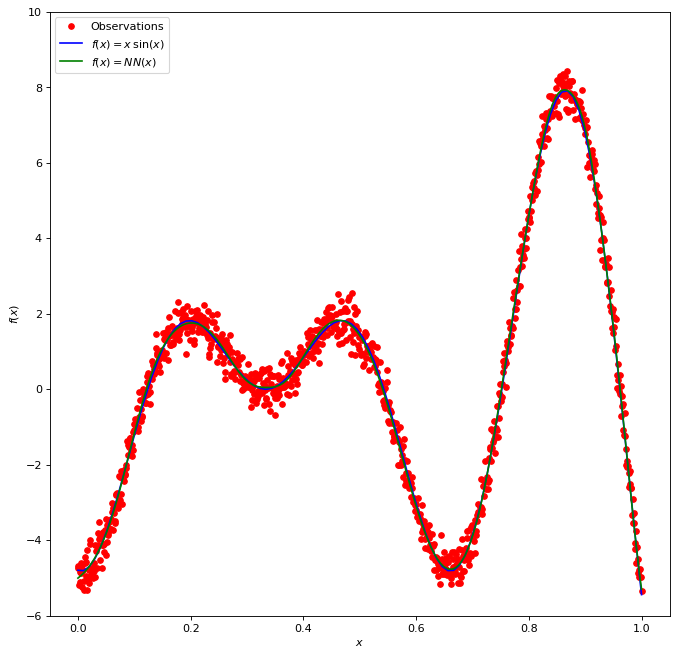

In [28]:
fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X.ravel(), Y.ravel(), 'r.', markersize=10, label=u'Observations')
plt.plot(x, func(x), 'b', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, ypredict, 'g', label=u'$f(x) = NN(x)$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

We can see that the Scikit-learn version of backpropagation is pretty good. Our neural network is able to correctly approximate the function $x \sin(x)$. In the next notebook, we'll look at how modern deep learning frameworks implement backpropagation and neural networks to further optimize them.